In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import cv2
from mountain_car import MountainCar

In [2]:
class AnimatedMountainCarVisualizer(MountainCar):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fig = None
        self.axes = None
        self.car_dot = None
        self.episode_text = None
        self.value_plot = None
        self.trajectory_line = None
        plt.style.use('dark_background')
    
    def calculate_value_function(self):
        """Calculate the state-value function for the current policy."""
        vel_step = (self.vel_min_max[1] - self.vel_min_max[0]) / 50
        pos_step = (self.pos_min_max[1] - self.pos_min_max[0]) / 50
        
        vel_vec = np.arange(self.vel_min_max[0], self.vel_min_max[1] + vel_step, vel_step)
        pos_vec = np.arange(self.pos_min_max[0], self.pos_min_max[1] + pos_step, pos_step)
        
        value_function = np.zeros((len(vel_vec), len(pos_vec)))
        for i, vel in enumerate(vel_vec):
            for j, pos in enumerate(pos_vec):
                value_function[i, j] = -max(self.q(vel, pos, a) for a in self.actions)
        
        return vel_vec, pos_vec, value_function
        
    def setup_animation(self, figsize=(15, 6)):
        """Initialize the animation figure and axes"""
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=figsize,
                                                      gridspec_kw={'width_ratios': [2, 1]})
        
        # Initialize value function plot
        vel_vec, pos_vec, value_function = self.calculate_value_function()
        norm_value = (value_function - value_function.min()) / (value_function.max() - value_function.min())
        self.value_plot = self.ax1.imshow(norm_value, 
                                          extent=[self.pos_min_max[0], self.pos_min_max[1],
                                                  self.vel_min_max[0], self.vel_min_max[1]],
                                          aspect='auto', origin='lower', cmap='YlOrRd_r')
        
        plt.colorbar(self.value_plot, ax=self.ax1)
        self.ax1.set_xlabel('position, x')
        self.ax1.set_ylabel('velocity, ẋ')
        
        # Initialize mountain plot
        x = np.linspace(self.pos_min_max[0], self.pos_min_max[1], 100)
        y = np.sin(3 * x) * 0.45 + 0.55
        self.ax2.plot(x, y, 'coral', linewidth=2)
        self.ax2.set_xlim(self.pos_min_max[0], self.pos_min_max[1])
        self.ax2.set_ylim(0, 1.1)
        self.ax2.axis('off')
        
        # Initialize car marker
        self.car_dot, = self.ax2.plot([], [], 'o', color='lightblue', markersize=10)
        
        # Initialize trajectory line
        self.trajectory_line, = self.ax1.plot([], [], color='white', linewidth=2, alpha=0.8)
        
        # Add episode text
        self.episode_text = self.ax1.text(0.02, 1.05, '', transform=self.ax1.transAxes)
        
        plt.tight_layout()
        
    def update_frame(self, episode):
        """Update function for each frame in the animation"""
        vel_vec, pos_vec, value_function = self.calculate_value_function()
        norm_value = (value_function - value_function.min()) / (value_function.max() - value_function.min())
        self.value_plot.set_array(norm_value)
        
        # Update episode text
        self.episode_text.set_text(f'Episode: {episode}')
        
        # Update trajectory and car position
        episode_data = self.results[self.results['episode'] == episode]
        
        # Update trajectory line
        self.trajectory_line.set_data(episode_data['pos'], episode_data['vel'])
        
        # Update car position
        final_pos = episode_data['pos'].iloc[-1]
        final_height = np.sin(3 * final_pos) * 0.45 + 0.55
        self.car_dot.set_data([final_pos], [final_height])
        
        return self.value_plot, self.car_dot, self.trajectory_line, self.episode_text
        
    def create_frames(self, output_dir='frames', episode_step=1):
        """Create frames and save them as images"""
        self.setup_animation()
        episodes = range(0, self.results['episode'].max() + 1, episode_step)
        
        for episode in episodes:
            self.update_frame(episode)
            filename = f"{output_dir}/frame_{episode:03d}.png"
            self.fig.savefig(filename)
        print("Frames saved successfully!")
        
    def create_mp4(self, frame_dir='frames', output_file='mountain_car_learning.mp4', fps=10):
        """Convert saved frames into an MP4 video using OpenCV"""
        # Get the list of image files
        images = [f"{frame_dir}/frame_{i:03d}.png" for i in range(self.results['episode'].max() + 1)]
        
        # Read the first image to get the size
        img = cv2.imread(images[0])
        height, width, layers = img.shape
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
        
        # Create VideoWriter object
        out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
        
        # Add each image to the video
        for image in images:
            frame = cv2.imread(image)
            out.write(frame)
        
        out.release()
        print(f"Video saved as {output_file}!")

def run_and_animate(alpha=0.1, distance_scaler=0.25, n_steps=4, episodes=500, episode_step=10):
    """
    Run the mountain car problem and create animation.
    
    Parameters:
    alpha : float
        Learning rate
    distance_scaler : float
        Distance scaling factor for RBF
    n_steps : int
        Number of steps for n-step SARSA
    episodes : int
        Number of episodes to run
    episode_step : int
        Number of episodes to skip between frames
    """
    # Initialize and run
    car = AnimatedMountainCarVisualizer(
        alpha=alpha,
        distance_scaler=distance_scaler,
        n=n_steps
    )
    
    print(f"Training for {episodes} episodes...")
    car.run(episodes)
    
    print("\nCreating frames...")
    car.create_frames(output_dir='frames', episode_step=episode_step)
    
    print("\nCreating MP4 video...")
    car.create_mp4(frame_dir='frames', output_file='mountain_car_learning.mp4', fps=10)
    
    return car

Training for 500 episodes...


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [02:10<00:00,  3.82it/s]



Creating frames...
Frames saved successfully!

Creating MP4 video...
Video saved as mountain_car_learning.mp4!


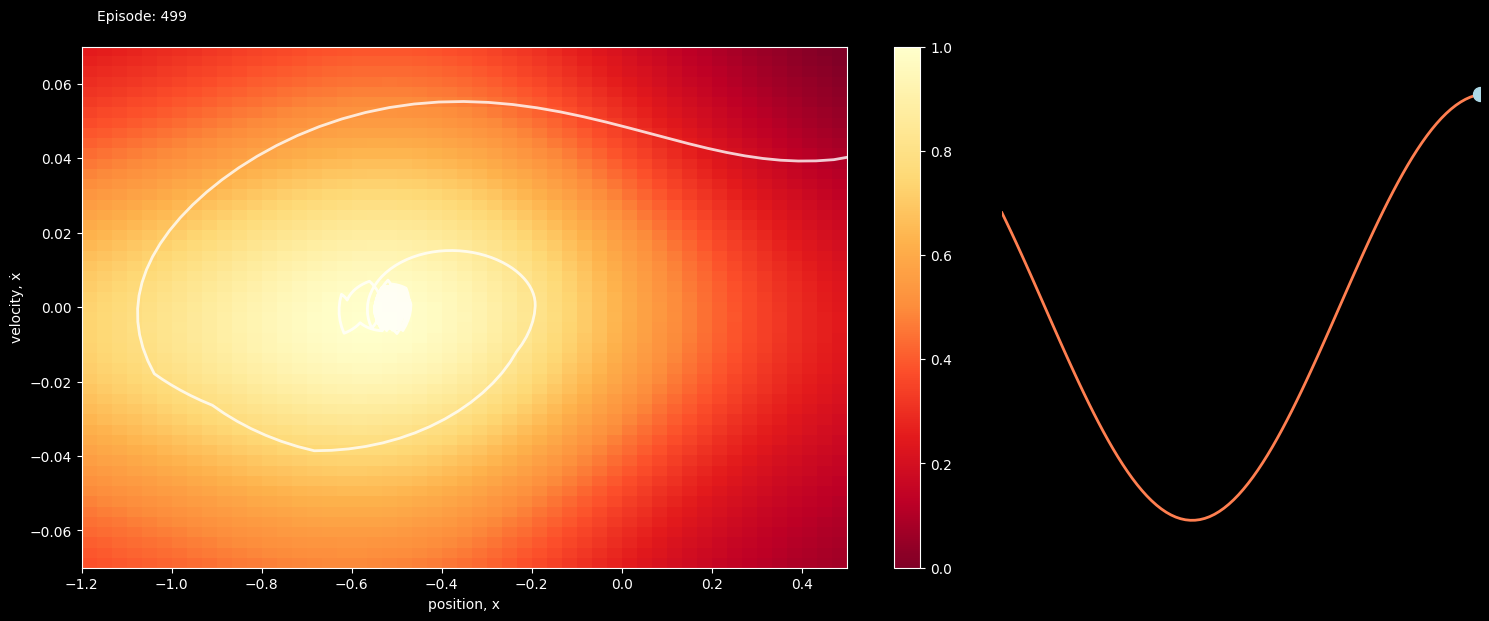

In [3]:
# Run the animation and save as MP4
car = run_and_animate(episodes=500, episode_step=1)